# Optimisation

## importing libraries 

In [24]:
import datetime


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pygad
import plotly.express as px
from tqdm import trange, tqdm

# Input

In [3]:
num_salles = 4
num_lits = 50

num_vacations = 1000
num_patients = 500
num_chiurgiens = 10

np.random.seed(0)

patients = pd.DataFrame({
    'index': np.arange(num_patients),
    'nom': np.random.choice(['Jean', 'Pierre', 'Paul', 'Jacques', 'Marie', 'Anne', 'Julie', 'Sophie', 'Marine', 'Marion'], size=num_patients),
    'qr_code': np.random.randint(0, 1000, size=num_patients),
})

positions = pd.DataFrame({
    'index': np.arange(num_patients),
    'patient': np.random.randint(0, 100, size=num_patients),
    'salle': np.random.randint(0, num_salles, size=num_patients),
})

vacations = pd.DataFrame({
    'index': np.arange(num_vacations),
    'chirurgien': np.random.randint(0, num_chiurgiens, num_vacations),
    'date_debut': np.random.randint(0, 100, num_vacations),
    'date_fin': np.random.randint(0, 100, num_vacations)
})

operations = pd.DataFrame({
    'index': np.arange(num_patients),
    'patient': np.random.randint(0, num_patients, size=num_patients),
    'duree_op': np.random.randint(30*60, 300*60, size=num_patients),
    'duree_sspi': np.random.randint(5*60, 60*60, size=num_patients),
    'duree_sejour': np.random.randint(1, 10, size=num_patients),
    'urgence': np.random.random(num_patients) > 0.8,
    'chirurgien': np.random.randint(0, num_chiurgiens, size=num_patients),
    'date_rdv': np.random.randint(-14*24*60*60, 0, size=num_patients) + 1695913686,
    # 'salle': np.random.randint(0, num_salles, size=num_patients),
})

# Lits

In [4]:
sejours_data = []
for _, operation in operations.iterrows():
    sejours_data.append({
        'operation': operation['index'],
        'date_entree': operation.date_rdv + np.random.randint(0, 7) * 24 * 60 * 60,
        'date_sortie': operation.date_rdv + operation.duree_sejour * 24 * 60 * 60
    })

sejours = pd.DataFrame(sejours_data)

In [13]:
def calculer_nb_patients(sejours_):
    sejours = np.array(sejours_[['date_entree', 'date_sortie']])
    nb_patients = np.ones(len(sejours))

    for i in range(len(sejours)):
        nb_patients[
            (sejours[:, 0] >= sejours[i, 0]) &
            (sejours[:, 0] < sejours[i, 1])
        ] += 1
    
    sejours = sejours_.copy()
    sejours['nb_patients'] = nb_patients.astype(int)
    sejours['conflits'] = (sejours.nb_patients - num_lits).clip(0)

    return sejours

In [1]:
calculer_nb_patients(sejours)

NameError: name 'calculer_nb_patients' is not defined

In [15]:
def conflits_lits(sejours):
    return calculer_nb_patients(sejours)['conflits'].sum()

In [16]:
conflits_lits(sejours)

12855

In [18]:
tolerance_urgence = 48 * 60 * 60

def conflits_urgence(sejours, operations):
    # join operations and sejours on operation index
    sejours_ = pd.merge(sejours, operations, left_on='operation', right_on='index', how='left')
    return sejours_.loc[
        (sejours_.date_entree - sejours_.date_rdv > tolerance_urgence) &
        (sejours_.urgence == True)
    ].shape[0]

In [19]:
conflits_urgence(sejours, operations)

43

In [72]:
step = 24 * 60 * 60
max_iter = 10000

def calculer_nb_conflits_lits(sejours):
    nb_patients = np.ones(len(sejours), dtype=int)

    for i in range(len(sejours)):
        nb_patients[
            (sejours[:, 0] >= sejours[i, 0]) &
            (sejours[:, 0] < sejours[i, 1])
        ] += 1
    
    return (nb_patients - num_lits).clip(0)

def resoudre_conflit_lits(sejours_):
    data = sejours_[['date_entree', 'date_sortie']].to_numpy()

    conflits = calculer_nb_conflits_lits(data)
    max_conflict = conflits.max()

    max_conflict_init = max_conflict
    # progress = tqdm(total=max_conflict_init)
    i = 0
    while max_conflict > 0 and i < max_iter:
        where = conflits == max_conflict
        data[where, 0] += step * np.random.randint(0, 5, size=(where.sum()))

        conflits = calculer_nb_conflits_lits(data)
        max_conflict = conflits.max()
        # progress.update(max_conflict_init - max_conflict)
        i += 1

    # progress.close()

    sejours = sejours_.copy()
    sejours['date_entree'] = data[:, 0]
    sejours['date_sortie'] = data[:, 1]
    sejours['conflits'] = conflits

    return sejours

In [73]:
sejours_resolu = resoudre_conflit_lits(sejours)

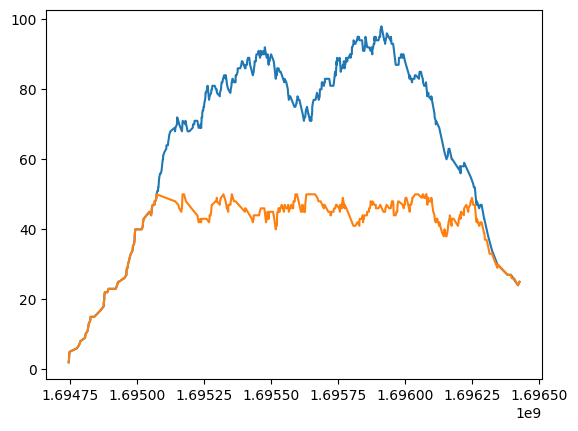

In [74]:
sejours = calculer_nb_patients(sejours)
sejours = sejours.sort_values('date_entree')

sejours_resolu = calculer_nb_patients(sejours_resolu)
sejours_resolu = sejours_resolu.sort_values('date_entree')

plt.plot(sejours.date_entree, sejours.nb_patients)
plt.plot(sejours_resolu.date_entree, sejours_resolu.nb_patients)

In [137]:
beta = 10

def calculer_cout(sejours, operations):
    sejours_ = pd.merge(sejours, operations, left_on='operation', right_on='index', how='left')
    alpha = 1 + sejours_.urgence * beta
    return ((sejours_.date_entree - sejours_.date_rdv) * alpha).sum() / 60 / 60 / 24

In [96]:
calculer_cout(sejours_resolu, operations)

483062400

## Optimisation

### Tabou

In [28]:
iters = 1000

best_solution = sejours_resolu.copy()
best_cout = calculer_cout(sejours_resolu, operations)
best_lit_conflict = conflits_lits(sejours_resolu) 
best_urgence_conflict = conflits_urgence(sejours_resolu, operations)

couts = [best_cout]
lit_conflicts = [best_lit_conflict]
urgence_conflicts = [best_urgence_conflict]

for i in trange(iters):
    solution = best_solution.copy()
    solution.date_entree += np.random.randint(-1, 1, size=len(solution)) * 24 * 60 * 60

    # make sure no patient is in the hospital before his operation
    solution.date_entree = np.maximum(solution.date_entree, operations.date_rdv[solution.operation])

    # resolve lit conflicts
    solution = resoudre_conflit_lits(solution)

    # solution = resoudre_conflit_lits_optimized(solution)
    cout = calculer_cout(solution, operations)
    lit_conflict = conflits_lits(solution)
    urgence_conflict = conflits_urgence(solution, operations)

    if cout < best_cout:
        best_solution = solution
        best_cout = cout
        best_lit_conflict = lit_conflict
        best_urgence_conflict = urgence_conflict

    # couts.append(cout)
    # lit_conflicts.append(lit_conflict)
    # urgence_conflicts.append(urgence_conflict)

    couts.append(best_cout)
    lit_conflicts.append(best_lit_conflict)
    urgence_conflicts.append(best_urgence_conflict)

couts = np.array(couts)
lit_conflicts = np.array(lit_conflicts)
urgence_conflicts = np.array(urgence_conflicts)


100%|██████████| 1000/1000 [01:26<00:00, 11.51it/s]


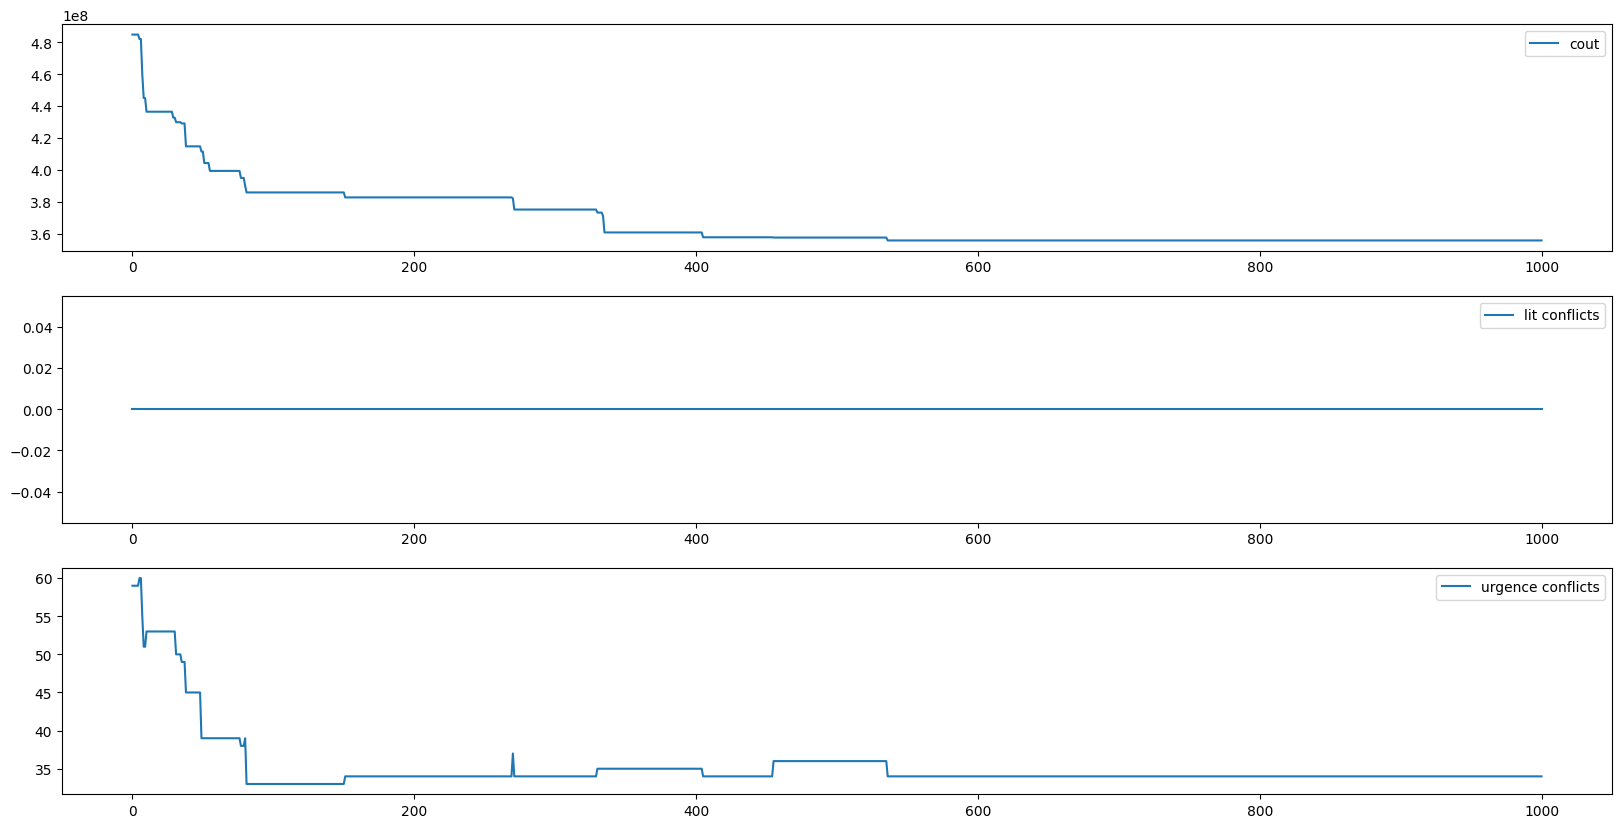

In [29]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10))

axes[0].plot(np.arange(iters + 1), couts, label='cout')
axes[0].legend()

axes[1].plot(np.arange(iters + 1), lit_conflicts, label='lit conflicts')
axes[1].legend()

axes[2].plot(np.arange(iters + 1), urgence_conflicts, label='urgence conflicts')
axes[2].legend()

### Algorithme génétique

In [138]:
def calculer_nb_conflits_urgences_(solution, sejours):
    urgences = operations.urgence[sejours.operation]
    dates_rdv = operations.date_rdv[sejours.operation]
    dates_entree = solution[:, 0]

    return ((dates_entree - dates_rdv > tolerance_urgence) & urgences).sum()

def calculer_cout_(solution, sejours, operations):
    urgences = operations.urgence[sejours.operation]
    dates_rdv = operations.date_rdv[sejours.operation]
    alpha = 1 + urgences * beta

    dates_entree = solution[:, 0]
    return ((dates_entree - dates_rdv) * alpha).sum() / 60 / 60 / 24

In [157]:
def fitness_func(gad, solution_, solution_idx):
    solution = solution_.reshape(-1, 2)

    conflicts_lits = calculer_nb_conflits_lits(solution).sum()
    conflicts_urgences = calculer_nb_conflits_urgences_(solution, sejours_resolu)
    cout = calculer_cout_(solution, sejours_resolu, operations)

    loss =  cout + conflicts_lits + conflicts_urgences
    return 1 - np.log(loss) 

In [175]:
def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

num_generations = 500
num_parents_mating = 32
mutation_percent_genes = 50

sol_per_pop = 64
num_genes = operations.shape[0] * 2

parent_selection_type = "sss"
crossover_type = "scattered"
mutation_type = "random"

In [176]:
initial_population = sejours_resolu[['date_entree', 'date_sortie']].to_numpy().flatten()
initial_population = np.tile(initial_population, (sol_per_pop, 1))
initial_population = initial_population + 0*np.random.randint(0, 5, size=initial_population.shape) * 24 * 60 * 60

Generation = 1
Fitness    = -7.639587725377334
Generation = 2
Fitness    = -7.639587725377334
Generation = 3
Fitness    = -7.639587695641351
Generation = 4
Fitness    = -7.639587695641351
Generation = 5
Fitness    = -7.639587695641351
Generation = 6
Fitness    = -7.63958767129234
Generation = 7
Fitness    = -7.639587490967912
Generation = 8
Fitness    = -7.639587356615934
Generation = 9
Fitness    = -7.6395871201468815
Generation = 10
Fitness    = -7.639586819895106
Generation = 11
Fitness    = -7.639586819895106
Generation = 12
Fitness    = -7.639586593253547
Generation = 13
Fitness    = -7.639586481222645
Generation = 14
Fitness    = -7.639586392881567
Generation = 15
Fitness    = -7.639586271031334
Generation = 16
Fitness    = -7.639586081222184
Generation = 17
Fitness    = -7.639585734353831
Generation = 18
Fitness    = -7.639585734353831
Generation = 19
Fitness    = -7.639585696725797
Generation = 20
Fitness    = -7.6395854784133
Generation = 21
Fitness    = -7.639585221740752
Gen

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Generation = 500
Fitness    = -7.639480734814306


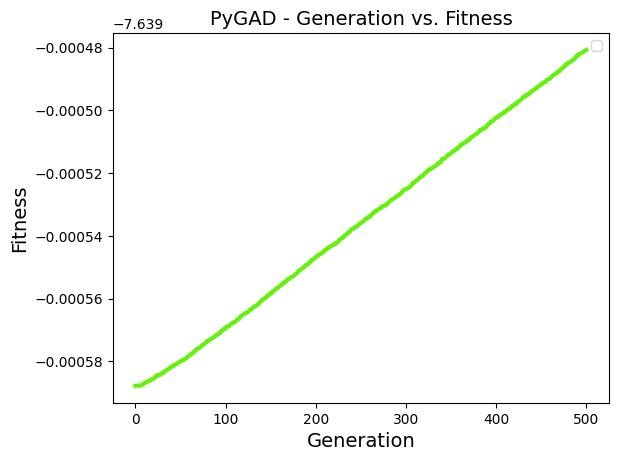

Fitness value of the best solution = -7.639480734814306
Index of the best solution : 34


In [177]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       mutation_percent_genes=mutation_percent_genes,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       on_generation=callback_generation)

ga_instance.run()
ga_instance.plot_fitness()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Fitness value of the best solution = {solution_fitness}")
print(f"Index of the best solution : {solution_idx}")


In [178]:
calculer_cout_(solution.reshape(-1, 2), sejours_resolu, operations) - calculer_cout(sejours_resolu, operations)

-0.6049908854065507

In [179]:
calculer_nb_conflits_urgences_(solution.reshape(-1, 2), sejours_resolu), calculer_nb_conflits_lits(solution.reshape(-1, 2)).sum()

(60, 0)

# Opérations

In [25]:
lookahead = 25
start_time = 8*60*60
end_time = 17*60*60

planning = np.arange(num_salles * lookahead).reshape(num_salles, lookahead)

In [77]:
def calculer_temps(planning, operations):
    date_offset = np.min(operations.date_rdv)
    start_offset = datetime.datetime.fromtimestamp(date_offset).replace(hour=0, minute=0, second=0, microsecond=0).timestamp()

    temps = np.zeros(planning.shape)
    for i in range(num_salles):
        days = 0
        time_of_day = start_time
        for j in range(lookahead):
            time_of_day += operations.duree_op[planning[i, j]]
            if time_of_day >= end_time:
                days += 1
                time_of_day = start_time
            temps[i, j] = start_offset + days * 24 * 60 * 60 + time_of_day
            
    return temps

In [78]:
temps = calculer_temps(planning, operations)
planning_flat = planning.flatten()

dates_debuts = temps.flatten()
dates_fins = dates_debuts + operations.duree_op[planning_flat]
urgence = operations.urgence[planning_flat]

gantt = pd.DataFrame({
    'salle': np.repeat(np.arange(num_salles), lookahead),
    'date_debut': pd.to_datetime(dates_debuts, unit='s'),
    'date_fin': pd.to_datetime(dates_fins, unit='s'),
    'urgence': urgence,

})

In [79]:
operations.duree_op[planning_flat] /3600

0     3.010833
1     1.329722
2     4.046944
3     1.361667
4     3.885556
        ...   
95    0.511389
96    1.482500
97    2.179722
98    1.709722
99    0.706667
Name: duree_op, Length: 100, dtype: float64

# GANTT patients

In [80]:
gantt

,salle,date_debut,date_fin,urgence
0,0,2023-09-14 11:00:39,2023-09-14 14:01:18,False
1,0,2023-09-14 12:20:26,2023-09-14 13:40:13,False
2,0,2023-09-14 16:23:15,2023-09-14 20:26:04,True
3,0,2023-09-15 08:00:00,2023-09-15 09:21:42,True
4,0,2023-09-15 11:53:08,2023-09-15 15:46:16,False
...,...,...,...,...
95,3,2023-09-18 11:03:33,2023-09-18 11:34:14,False
96,3,2023-09-18 12:32:30,2023-09-18 14:01:27,False
97,3,2023-09-18 14:43:17,2023-09-18 16:54:04,False
98,3,2023-09-18 16:25:52,2023-09-18 18:08:27,False


In [70]:
px.timeline(gantt, x_start="date_debut", x_end="date_fin", y="salle", color="urgence")

/home/codespace/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
def critere_chirurgiens(planning, operations):
    chirugiens = dates_operations.chirurgien.unique()
    conflicts = 0
    for chirugien in chirugiens:
        df = dates_operations.query(f"chirurgien == {chirugien}").sort_values('debut_op')
        for i in range(len(df)):
            if i > 0 and df.iloc[i]['debut_op'] > df.iloc[i - 1]['fin_op']:
                conflicts += 1
    return conflicts

# Autre

In [ ]:
def calculer_dates(planning, operations):
    dates_operations = operations.copy()
    dates_operations['salle'] = np.nan
    dates_operations['debut_op'] = np.nan
    dates_operations['fin_op'] = np.nan

    for salle in range(num_salles):
        time = 1695913686
        for operation in planning[salle]:
            dates_operations.loc[operation, 'salle'] = salle
            dates_operations.loc[operation, 'debut_op'] = time
            dates_operations.loc[operation, 'fin_op'] = time + dates_operations.loc[operation, 'duree_op']
            time += dates_operations.loc[operation, 'duree_op']
    return dates_operations

In [ ]:
# random planning
np.random.seed(42)
planning = np.random.permutation(num_patients).reshape(num_salles, -1)
planning

In [ ]:
calculer_dates(planning, operations)

In [ ]:
def critere_chirurgiens(planning, operations):
    dates_operations = calculer_dates(planning, operations)
            
    chirugiens = dates_operations.chirurgien.unique()
    conflicts = 0
    for chirugien in chirugiens:
        df = dates_operations.query(f"chirurgien == {chirugien}").sort_values('debut_op')
        for i in range(len(df)):
            if i > 0 and df.iloc[i]['debut_op'] > df.iloc[i - 1]['fin_op']:
                conflicts += 1
    return conflicts

In [ ]:
def critere_urgences(planning, operations):
    dates_operations = calculer_dates(planning, operations)
    urgences = dates_operations.query("urgence == True")
    conflicts = 0
    for i in range(len(urgences)):
        operation = urgences.iloc[i]
        if operation['date_entree'] + 48 * 60 < operation['debut_op']:
            conflicts += 1
    return conflicts

In [ ]:
df = calculer_dates(planning, operations)
df.debut_op = pd.to_datetime(df.debut_op, unit='s')
df.fin_op = pd.to_datetime(df.fin_op, unit='s')

fig = px.timeline(df, x_start="debut_op", x_end="fin_op", y="salle", color="urgence", hover_name="index")
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

In [ ]:
critere_urgences(planning, operations)